# MiniDataChallengeSteering 

In [98]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
%matplotlib inline

In [99]:
from astropy.io import fits

In [100]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [101]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [102]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialisation

## Python Packages

In [104]:
PATH_LSSTFiltersKG='./LSSTFiltersKG'
PATH_ATMPARAMSIM='./atmparamsim'
PATH_ATMTRANSPSIM='./libradtransim'
PATH_CADENCE='./cadence'
PATH_LSSTPHOTO='./lsstphotometry'
PATH_SED='./pysynphotsed'

In [105]:
sys.path.append(PATH_LSSTFiltersKG)
sys.path.append(PATH_ATMPARAMSIM)
sys.path.append(PATH_ATMTRANSPSIM)
sys.path.append(PATH_CADENCE)
sys.path.append(PATH_LSSTPHOTO)
sys.path.append(PATH_SED)

In [106]:
import libsimulateTranspLSSTScattAbsAer as atm
import libLSSTPhotometry as photo
import libLSSTFiltersKG as lsst
import libpysynphotgridsed as sed

## Input file

### Cadence file with atmospheric variation 

- the file has been generated from cadence and atmospheric variation in **GenerateCadenceAtmProgram.ipynb**

In [107]:
cadence_atm_program_file='cadence_field1000_atm.csv'

## Output file

- file with star magnitudes from which one must retrieve atmospheric parameters from the star magnitudes

In [108]:
packet=1
packetsize=50

In [109]:
output_file='cadence_field1000_atm_sim_{}.fits'.format(packet)
NROWMIN=(packet-1)*packetsize
NROWMAX=(packet)*packetsize-1
print 'file=',output_file,' NROWMIN=',NROWMIN,' NROWMAX=',NROWMAX

file= cadence_field1000_atm_sim_1.fits  NROWMIN= 0  NROWMAX= 49


## index

In [110]:
idx_out_num=0
idx_out_night=1
idx_out_expdate=2
idx_out_expmjd=3
idx_out_am=4
idx_out_filt=5
idx_out_vaod=6
idx_out_pwv=7
idx_out_o3=8
idx_out_res=9

# The atmospheric conditions

In [111]:
df=pd.read_csv(cadence_atm_program_file,index_col=False)

In [112]:
#df=df.iloc[NROWMIN:NROWMAX+1]

In [113]:
df.head()

,Unnamed: 0,Unnamed: 0.1,obshistid,nights,expdate,expmjd,airmass,filter,finseeing,transparency,filtskybrightness,fiveSigmaDepth,rawseeing,humidity,vaod,pwv,o3,cloud
0,0,0,127633,173,14965194,59753.208268,1.370996,g,1.160634,0.25,21.732956,24.241311,0.704040,0.0,0.054710,7.476145,276.576499,10.649871
1,1,1,127670,173,14966692,59753.225609,1.274001,g,1.303756,0.25,21.791891,24.160844,0.859973,0.0,0.044534,6.894512,273.848317,1.183331
2,2,2,136947,189,16353504,59769.276675,1.025141,z,0.695528,0.00,19.037479,23.215870,0.504610,0.0,0.091342,6.312880,295.673768,1.183331
3,3,3,136993,189,16355480,59769.299544,1.012049,z,0.659361,0.00,19.223263,23.364350,0.462390,0.0,0.054710,13.874105,257.479229,1.183331
4,4,4,137990,190,16439213,59770.268672,1.030291,y,0.782293,0.00,17.300000,21.767917,0.633086,0.0,0.064885,9.802676,290.217405,1.183331


In [114]:
df.describe()

,Unnamed: 0,Unnamed: 0.1,obshistid,nights,expdate,expmjd,airmass,finseeing,transparency,filtskybrightness,fiveSigmaDepth,rawseeing,humidity,vaod,pwv,o3,cloud
count,912.000000,912.000000,9.120000e+02,912.000000,9.120000e+02,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.000000,912.0,912.000000,912.000000,912.000000,912.000000
mean,455.500000,455.500000,1.353989e+06,1996.481360,1.725118e+08,61576.664671,1.216682,0.946423,0.135965,19.480077,23.071331,0.652962,0.0,0.052920,8.346043,272.134230,5.376842
std,263.416021,263.416021,6.749863e+05,1006.667221,8.697478e+07,1006.652540,0.134956,0.205151,0.198053,1.784550,1.057774,0.201697,0.0,0.018289,4.059142,18.853135,11.250297
min,0.000000,0.000000,1.276330e+05,173.000000,1.496519e+07,59753.208268,1.010873,0.550999,0.000000,16.332019,20.909705,0.212684,0.0,0.024183,1.078185,230.197417,1.183331
25%,227.750000,227.750000,8.365668e+05,1223.000000,1.056970e+08,60803.345134,1.095562,0.786528,0.000000,17.300000,22.118978,0.506298,0.0,0.038429,5.731247,257.479229,1.183331
50%,455.500000,455.500000,1.387090e+06,2030.500000,1.754551e+08,61610.730403,1.212443,0.906078,0.000000,19.965937,23.207572,0.618785,0.0,0.050639,7.476145,268.391955,1.183331
75%,683.250000,683.250000,1.897182e+06,2798.000000,2.417535e+08,62378.073410,1.342497,1.080563,0.250000,21.104146,23.995230,0.769933,0.0,0.060815,10.384309,284.761042,3.549966
max,911.000000,911.000000,2.434258e+06,3627.000000,3.133765e+08,63207.043279,1.503813,1.501938,0.625000,22.237331,24.919995,1.456743,0.0,0.123904,26.088393,358.421937,114.781808


In [115]:
NbAtmSimul=len(df)

## Atmospheric simulation

In [116]:
all_wl=[]
all_atmtran=[]

In [117]:
#NbAtmSimul=10
lambda0_aerosol=500. # nm

In [118]:
photo_atm=photo.Atmosphere('libradtran')

In [119]:
index=0
while index<NbAtmSimul:
    am=df['airmass'].iloc[index]
    pwv=df['pwv'].iloc[index]
    ozone=df['o3'].iloc[index]
    tau_aerosol=df['vaod'].iloc[index]
    print '**************************************************************************************************'
    print '*  atmospheric simulation with libradtran : idx=',index,' am=',am,' vaod=',tau_aerosol,' pwv=',pwv,' O3=',ozone ,' *'
    '********************************************************************************************************'
    path,thefile=atm.ProcessSimulationaer(am,pwv,ozone,lambda0_aerosol,tau_aerosol) 
    fullfilename=os.path.join(path,thefile)
    atm_data=np.loadtxt(fullfilename)
    wl_atm=atm_data[:,0]
    tr_atm=atm_data[:,1]  
    all_wl.append(wl_atm)
    all_atmtran.append(tr_atm) 
    if index==0:
        nbcols=len(wl_atm)
        nbrows=NbAtmSimul+1
        data_atm=np.zeros((nbrows,nbcols))
        data_atm[0,:]=wl_atm
    index+=1
    data_atm[index,:]=tr_atm

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 0  am= 1.370996  vaod= 0.0547096473775  pwv= 7.47614508384  O3= 276.576498542  *
--------------------------------------------
 1) airmass =  1.370996
 2) pwv =  7.47614508384
 3) oz =  276.576498542
 4) wl0 =  500.0
 5) tau0 =  0.0547096473775
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv74_oz27_aer5.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 1  am= 1.274001  vaod= 0.0445340086256  pwv= 6.89451232748  O3= 273.848317247  *
--------------------------------------------
 1) airmass =  1.274001
 2) pwv =  6.89451232748
 3) oz =  273.848317247
 4) wl0 =  500.0
 5) tau0 =  0.0445340086256
----------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 16  am= 1.347676  vaod= 0.0750609248814  pwv= 5.14961405841  O3= 273.848317247  *
--------------------------------------------
 1) airmass =  1.347676
 2) pwv =  5.14961405841
 3) oz =  273.848317247
 4) wl0 =  500.0
 5) tau0 =  0.0750609248814
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv51_oz27_aer7.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 17  am= 1.266911  vaod= 0.0587799028783  pwv= 5.14961405841  O3= 260.207410772  *
--------------------------------------------
 1) airmass =  1.266911
 2) pwv =  5.14961405841
 3) oz =  260.207410772
 4) wl0 =  500.0
 5) tau0 =  0.0587799028783
--------------------------------

!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv92_oz29_aer5.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 32  am= 1.058005  vaod= 0.046569136376  pwv= 17.3639019419  O3= 279.304679837  *
--------------------------------------------
 1) airmass =  1.058005
 2) pwv =  17.3639019419
 3) oz =  279.304679837
 4) wl0 =  500.0
 5) tau0 =  0.046569136376
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv173_oz27_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 33  am= 1.064311  vaod= 0.036393497624  pwv= 12.1292071347  O3= 279.304679837  *
--------------------------------------------
 1) airmass =  

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 51  am= 1.07554  vaod= 0.0343583698736  pwv= 7.47614508384  O3= 295.673767606  *
--------------------------------------------
 1) airmass =  1.07554
 2) pwv =  7.47614508384
 3) oz =  295.673767606
 4) wl0 =  500.0
 5) tau0 =  0.0343583698736
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv74_oz29_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv74_oz29_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv74_oz29_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv74_oz29_aer3.OUT')
*******************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 60  am= 1.303952  vaod= 0.0994824578861  pwv= 10.965941622  O3= 265.663773362  *
--------------------------------------------
 1) airmass =  1.303952
 2) pwv =  10.965941622
 3) oz =  265.663773362
 4) wl0 =  500.0
 5) tau0 =  0.0994824578861
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv109_oz26_aer9.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv109_oz26_aer9.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv109_oz26_aer9.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv109_oz26_aer9.OUT')
***************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 69  am= 1.282701  vaod= 0.0486042641264  pwv= 6.89451232748  O3= 252.022866888  *
--------------------------------------------
 1) airmass =  1.282701
 2) pwv =  6.89451232748
 3) oz =  252.022866888
 4) wl0 =  500.0
 5) tau0 =  0.0486042641264
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv68_oz25_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv68_oz25_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv68_oz25_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv68_oz25_aer4.OUT')
*****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 78  am= 1.30199  vaod= 0.046569136376  pwv= 12.1292071347  O3= 295.673767606  *
--------------------------------------------
 1) airmass =  1.30199
 2) pwv =  12.1292071347
 3) oz =  295.673767606
 4) wl0 =  500.0
 5) tau0 =  0.046569136376
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv121_oz29_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv121_oz29_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv121_oz29_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv121_oz29_aer4.OUT')
*****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 87  am= 1.114766  vaod= 0.0486042641264  pwv= 9.80267610927  O3= 260.207410772  *
--------------------------------------------
 1) airmass =  1.114766
 2) pwv =  9.80267610927
 3) oz =  260.207410772
 4) wl0 =  500.0
 5) tau0 =  0.0486042641264
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv98_oz26_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv98_oz26_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv98_oz26_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv98_oz26_aer4.OUT')
*****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 97  am= 1.294765  vaod= 0.0384286253744  pwv= 15.6190036728  O3= 284.761042427  *
--------------------------------------------
 1) airmass =  1.294765
 2) pwv =  15.6190036728
 3) oz =  284.761042427
 4) wl0 =  500.0
 5) tau0 =  0.0384286253744
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv156_oz28_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv156_oz28_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv156_oz28_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv156_oz28_aer3.OUT')
*************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 106  am= 1.033069  vaod= 0.0689555416303  pwv= 18.5271674546  O3= 276.576498542  *
--------------------------------------------
 1) airmass =  1.033069
 2) pwv =  18.5271674546
 3) oz =  276.576498542
 4) wl0 =  500.0
 5) tau0 =  0.0689555416303
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv185_oz27_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv185_oz27_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv185_oz27_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv185_oz27_aer6.OUT')
************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 115  am= 1.270693  vaod= 0.0587799028783  pwv= 13.8741054038  O3= 282.032861132  *
--------------------------------------------
 1) airmass =  1.270693
 2) pwv =  13.8741054038
 3) oz =  282.032861132
 4) wl0 =  500.0
 5) tau0 =  0.0587799028783
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv138_oz28_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv138_oz28_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv138_oz28_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv138_oz28_aer5.OUT')
************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 125  am= 1.091479  vaod= 0.0526745196272  pwv= 8.05777784019  O3= 273.848317247  *
--------------------------------------------
 1) airmass =  1.091479
 2) pwv =  8.05777784019
 3) oz =  273.848317247
 4) wl0 =  500.0
 5) tau0 =  0.0526745196272
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv80_oz27_aer5.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 126  am= 1.152876  vaod= 0.0954122023853  pwv= 3.40471578933  O3= 292.945586311  *
--------------------------------------------
 1) airmass =  1.152876
 2) pwv =  3.40471578933
 3) oz =  292.945586311
 4) wl0 =  500.0
 5) tau0 =  0.0954122023853
------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 135  am= 1.368819  vaod= 0.046569136376  pwv= 5.73124681476  O3= 254.751048183  *
--------------------------------------------
 1) airmass =  1.368819
 2) pwv =  5.73124681476
 3) oz =  254.751048183
 4) wl0 =  500.0
 5) tau0 =  0.046569136376
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv57_oz25_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 136  am= 1.409686  vaod= 0.0608150306287  pwv= 6.31287957112  O3= 273.848317247  *
--------------------------------------------
 1) airmass =  1.409686
 2) pwv =  6.31287957112
 3) oz =  273.848317247
 4) wl0 =  500.0
 5) tau0 =  0.0608150306287
--------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 145  am= 1.350631  vaod= 0.101517585637  pwv= 5.14961405841  O3= 271.120135952  *
--------------------------------------------
 1) airmass =  1.350631
 2) pwv =  5.14961405841
 3) oz =  271.120135952
 4) wl0 =  500.0
 5) tau0 =  0.101517585637
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv51_oz27_aer10.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv51_oz27_aer10.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv51_oz27_aer10.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv51_oz27_aer10.OUT')
**************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 155  am= 1.044756  vaod= 0.0506393918768  pwv= 8.63941059655  O3= 271.120135952  *
--------------------------------------------
 1) airmass =  1.044756
 2) pwv =  8.63941059655
 3) oz =  271.120135952
 4) wl0 =  500.0
 5) tau0 =  0.0506393918768
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv86_oz27_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv86_oz27_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv86_oz27_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv86_oz27_aer5.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 165  am= 1.279104  vaod= 0.0526745196272  pwv= 8.05777784019  O3= 268.391954657  *
--------------------------------------------
 1) airmass =  1.279104
 2) pwv =  8.05777784019
 3) oz =  268.391954657
 4) wl0 =  500.0
 5) tau0 =  0.0526745196272
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv80_oz26_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv80_oz26_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv80_oz26_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv80_oz26_aer5.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 174  am= 1.376739  vaod= 0.046569136376  pwv= 4.56798130205  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.376739
 2) pwv =  4.56798130205
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.046569136376
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv45_oz25_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 175  am= 1.270903  vaod= 0.0506393918768  pwv= 9.22104335291  O3= 252.022866888  *
--------------------------------------------
 1) airmass =  1.270903
 2) pwv =  9.22104335291
 3) oz =  252.022866888
 4) wl0 =  500.0
 5) tau0 =  0.0506393918768
--------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 185  am= 1.34455  vaod= 0.0445340086256  pwv= 4.56798130205  O3= 252.022866888  *
--------------------------------------------
 1) airmass =  1.34455
 2) pwv =  4.56798130205
 3) oz =  252.022866888
 4) wl0 =  500.0
 5) tau0 =  0.0445340086256
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv45_oz25_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 186  am= 1.161408  vaod= 0.0486042641264  pwv= 7.47614508384  O3= 254.751048183  *
--------------------------------------------
 1) airmass =  1.161408
 2) pwv =  7.47614508384
 3) oz =  254.751048183
 4) wl0 =  500.0
 5) tau0 =  0.0486042641264
--------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 196  am= 1.227162  vaod= 0.0445340086256  pwv= 7.47614508384  O3= 276.576498542  *
--------------------------------------------
 1) airmass =  1.227162
 2) pwv =  7.47614508384
 3) oz =  276.576498542
 4) wl0 =  500.0
 5) tau0 =  0.0445340086256
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv74_oz27_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 197  am= 1.347321  vaod= 0.0384286253744  pwv= 12.1292071347  O3= 279.304679837  *
--------------------------------------------
 1) airmass =  1.347321
 2) pwv =  12.1292071347
 3) oz =  279.304679837
 4) wl0 =  500.0
 5) tau0 =  0.0384286253744
------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 206  am= 1.199345  vaod= 0.0343583698736  pwv= 1.0781847639  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.199345
 2) pwv =  1.0781847639
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.0343583698736
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv10_oz25_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv10_oz25_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv10_oz25_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv10_oz25_aer3.OUT')
******************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 217  am= 1.372289  vaod= 0.0608150306287  pwv= 3.40471578933  O3= 260.207410772  *
--------------------------------------------
 1) airmass =  1.372289
 2) pwv =  3.40471578933
 3) oz =  260.207410772
 4) wl0 =  500.0
 5) tau0 =  0.0608150306287
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv34_oz26_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv34_oz26_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv34_oz26_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv34_oz26_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 226  am= 1.473198  vaod= 0.0526745196272  pwv= 4.56798130205  O3= 287.489223722  *
--------------------------------------------
 1) airmass =  1.473198
 2) pwv =  4.56798130205
 3) oz =  287.489223722
 4) wl0 =  500.0
 5) tau0 =  0.0526745196272
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z14_wv45_oz28_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z14_wv45_oz28_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z14_wv45_oz28_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z14_wv45_oz28_aer5.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 236  am= 1.297258  vaod= 0.0424988808752  pwv= 10.3843088656  O3= 284.761042427  *
--------------------------------------------
 1) airmass =  1.297258
 2) pwv =  10.3843088656
 3) oz =  284.761042427
 4) wl0 =  500.0
 5) tau0 =  0.0424988808752
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv103_oz28_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv103_oz28_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv103_oz28_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv103_oz28_aer4.OUT')
************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 246  am= 1.086527  vaod= 0.0486042641264  pwv= 3.98634854569  O3= 249.294685593  *
--------------------------------------------
 1) airmass =  1.086527
 2) pwv =  3.98634854569
 3) oz =  249.294685593
 4) wl0 =  500.0
 5) tau0 =  0.0486042641264
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv39_oz24_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv39_oz24_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv39_oz24_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv39_oz24_aer4.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 256  am= 1.289537  vaod= 0.0648852861295  pwv= 5.73124681476  O3= 282.032861132  *
--------------------------------------------
 1) airmass =  1.289537
 2) pwv =  5.73124681476
 3) oz =  282.032861132
 4) wl0 =  500.0
 5) tau0 =  0.0648852861295
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv57_oz28_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv57_oz28_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv57_oz28_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv57_oz28_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 265  am= 1.467325  vaod= 0.046569136376  pwv= 13.2924726474  O3= 265.663773362  *
--------------------------------------------
 1) airmass =  1.467325
 2) pwv =  13.2924726474
 3) oz =  265.663773362
 4) wl0 =  500.0
 5) tau0 =  0.046569136376
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z14_wv132_oz26_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z14_wv132_oz26_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z14_wv132_oz26_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z14_wv132_oz26_aer4.OUT')
**************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 274  am= 1.311623  vaod= 0.0669204138799  pwv= 8.05777784019  O3= 292.945586311  *
--------------------------------------------
 1) airmass =  1.311623
 2) pwv =  8.05777784019
 3) oz =  292.945586311
 4) wl0 =  500.0
 5) tau0 =  0.0669204138799
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv80_oz29_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv80_oz29_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv80_oz29_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv80_oz29_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 284  am= 1.033831  vaod= 0.0282529866225  pwv= 5.14961405841  O3= 282.032861132  *
--------------------------------------------
 1) airmass =  1.033831
 2) pwv =  5.14961405841
 3) oz =  282.032861132
 4) wl0 =  500.0
 5) tau0 =  0.0282529866225
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv51_oz28_aer2.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv51_oz28_aer2.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv51_oz28_aer2.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv51_oz28_aer2.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 294  am= 1.146257  vaod= 0.0384286253744  pwv= 5.73124681476  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.146257
 2) pwv =  5.73124681476
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.0384286253744
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv57_oz25_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv57_oz25_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv57_oz25_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv57_oz25_aer3.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 305  am= 1.359105  vaod= 0.0608150306287  pwv= 6.89451232748  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.359105
 2) pwv =  6.89451232748
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.0608150306287
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv68_oz25_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv68_oz25_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv68_oz25_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv68_oz25_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 315  am= 1.398424  vaod= 0.0750609248814  pwv= 4.56798130205  O3= 254.751048183  *
--------------------------------------------
 1) airmass =  1.398424
 2) pwv =  4.56798130205
 3) oz =  254.751048183
 4) wl0 =  500.0
 5) tau0 =  0.0750609248814
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv45_oz25_aer7.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv45_oz25_aer7.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv45_oz25_aer7.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv45_oz25_aer7.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 324  am= 1.39608  vaod= 0.046569136376  pwv= 3.40471578933  O3= 262.935592067  *
--------------------------------------------
 1) airmass =  1.39608
 2) pwv =  3.40471578933
 3) oz =  262.935592067
 4) wl0 =  500.0
 5) tau0 =  0.046569136376
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv34_oz26_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 325  am= 1.298123  vaod= 0.0282529866225  pwv= 10.3843088656  O3= 279.304679837  *
--------------------------------------------
 1) airmass =  1.298123
 2) pwv =  10.3843088656
 3) oz =  279.304679837
 4) wl0 =  500.0
 5) tau0 =  0.0282529866225
----------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 335  am= 1.185972  vaod= 0.036393497624  pwv= 13.2924726474  O3= 273.848317247  *
--------------------------------------------
 1) airmass =  1.185972
 2) pwv =  13.2924726474
 3) oz =  273.848317247
 4) wl0 =  500.0
 5) tau0 =  0.036393497624
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv132_oz27_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv132_oz27_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv132_oz27_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv132_oz27_aer3.OUT')
**************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 345  am= 1.087031  vaod= 0.0994824578861  pwv= 3.98634854569  O3= 243.838323003  *
--------------------------------------------
 1) airmass =  1.087031
 2) pwv =  3.98634854569
 3) oz =  243.838323003
 4) wl0 =  500.0
 5) tau0 =  0.0994824578861
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv39_oz24_aer9.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv39_oz24_aer9.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv39_oz24_aer9.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv39_oz24_aer9.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 355  am= 1.282187  vaod= 0.0486042641264  pwv= 10.3843088656  O3= 295.673767606  *
--------------------------------------------
 1) airmass =  1.282187
 2) pwv =  10.3843088656
 3) oz =  295.673767606
 4) wl0 =  500.0
 5) tau0 =  0.0486042641264
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv103_oz29_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv103_oz29_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv103_oz29_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv103_oz29_aer4.OUT')
************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 367  am= 1.016498  vaod= 0.0445340086256  pwv= 3.98634854569  O3= 287.489223722  *
--------------------------------------------
 1) airmass =  1.016498
 2) pwv =  3.98634854569
 3) oz =  287.489223722
 4) wl0 =  500.0
 5) tau0 =  0.0445340086256
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv39_oz28_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv39_oz28_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv39_oz28_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv39_oz28_aer4.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 377  am= 1.144284  vaod= 0.0547096473775  pwv= 6.89451232748  O3= 287.489223722  *
--------------------------------------------
 1) airmass =  1.144284
 2) pwv =  6.89451232748
 3) oz =  287.489223722
 4) wl0 =  500.0
 5) tau0 =  0.0547096473775
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv68_oz28_aer5.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 378  am= 1.200132  vaod= 0.0669204138799  pwv= 1.65981752026  O3= 295.673767606  *
--------------------------------------------
 1) airmass =  1.200132
 2) pwv =  1.65981752026
 3) oz =  295.673767606
 4) wl0 =  500.0
 5) tau0 =  0.0669204138799
------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 387  am= 1.014335  vaod= 0.0852365636334  pwv= 7.47614508384  O3= 260.207410772  *
--------------------------------------------
 1) airmass =  1.014335
 2) pwv =  7.47614508384
 3) oz =  260.207410772
 4) wl0 =  500.0
 5) tau0 =  0.0852365636334
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv74_oz26_aer8.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv74_oz26_aer8.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv74_oz26_aer8.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv74_oz26_aer8.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 397  am= 1.070498  vaod= 0.0913419468846  pwv= 5.73124681476  O3= 252.022866888  *
--------------------------------------------
 1) airmass =  1.070498
 2) pwv =  5.73124681476
 3) oz =  252.022866888
 4) wl0 =  500.0
 5) tau0 =  0.0913419468846
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv57_oz25_aer9.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv57_oz25_aer9.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv57_oz25_aer9.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv57_oz25_aer9.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 407  am= 1.168187  vaod= 0.0689555416303  pwv= 9.80267610927  O3= 271.120135952  *
--------------------------------------------
 1) airmass =  1.168187
 2) pwv =  9.80267610927
 3) oz =  271.120135952
 4) wl0 =  500.0
 5) tau0 =  0.0689555416303
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv98_oz27_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv98_oz27_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv98_oz27_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv98_oz27_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 417  am= 1.359759  vaod= 0.0608150306287  pwv= 3.40471578933  O3= 317.499217966  *
--------------------------------------------
 1) airmass =  1.359759
 2) pwv =  3.40471578933
 3) oz =  317.499217966
 4) wl0 =  500.0
 5) tau0 =  0.0608150306287
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv34_oz31_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv34_oz31_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv34_oz31_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv34_oz31_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 427  am= 1.280002  vaod= 0.0587799028783  pwv= 6.89451232748  O3= 284.761042427  *
--------------------------------------------
 1) airmass =  1.280002
 2) pwv =  6.89451232748
 3) oz =  284.761042427
 4) wl0 =  500.0
 5) tau0 =  0.0587799028783
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv68_oz28_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv68_oz28_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv68_oz28_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv68_oz28_aer5.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 437  am= 1.046279  vaod= 0.0608150306287  pwv= 8.63941059655  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.046279
 2) pwv =  8.63941059655
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.0608150306287
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv86_oz25_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv86_oz25_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv86_oz25_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv86_oz25_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 448  am= 1.084806  vaod= 0.0445340086256  pwv= 10.3843088656  O3= 287.489223722  *
--------------------------------------------
 1) airmass =  1.084806
 2) pwv =  10.3843088656
 3) oz =  287.489223722
 4) wl0 =  500.0
 5) tau0 =  0.0445340086256
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv103_oz28_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv103_oz28_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv103_oz28_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv103_oz28_aer4.OUT')
************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 459  am= 1.321737  vaod= 0.0608150306287  pwv= 7.47614508384  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.321737
 2) pwv =  7.47614508384
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.0608150306287
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv74_oz25_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv74_oz25_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv74_oz25_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv74_oz25_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 469  am= 1.212772  vaod= 0.0282529866225  pwv= 5.14961405841  O3= 287.489223722  *
--------------------------------------------
 1) airmass =  1.212772
 2) pwv =  5.14961405841
 3) oz =  287.489223722
 4) wl0 =  500.0
 5) tau0 =  0.0282529866225
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv51_oz28_aer2.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv51_oz28_aer2.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv51_oz28_aer2.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv51_oz28_aer2.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 478  am= 1.094121  vaod= 0.046569136376  pwv= 8.63941059655  O3= 254.751048183  *
--------------------------------------------
 1) airmass =  1.094121
 2) pwv =  8.63941059655
 3) oz =  254.751048183
 4) wl0 =  500.0
 5) tau0 =  0.046569136376
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv86_oz25_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 479  am= 1.059439  vaod= 0.036393497624  pwv= 18.5271674546  O3= 287.489223722  *
--------------------------------------------
 1) airmass =  1.059439
 2) pwv =  18.5271674546
 3) oz =  287.489223722
 4) wl0 =  500.0
 5) tau0 =  0.036393497624
----------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 491  am= 1.148053  vaod= 0.0648852861295  pwv= 3.40471578933  O3= 312.042855376  *
--------------------------------------------
 1) airmass =  1.148053
 2) pwv =  3.40471578933
 3) oz =  312.042855376
 4) wl0 =  500.0
 5) tau0 =  0.0648852861295
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv34_oz31_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv34_oz31_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv34_oz31_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv34_oz31_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 501  am= 1.133213  vaod= 0.0608150306287  pwv= 8.63941059655  O3= 254.751048183  *
--------------------------------------------
 1) airmass =  1.133213
 2) pwv =  8.63941059655
 3) oz =  254.751048183
 4) wl0 =  500.0
 5) tau0 =  0.0608150306287
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv86_oz25_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv86_oz25_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv86_oz25_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv86_oz25_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 511  am= 1.126553  vaod= 0.0323232421233  pwv= 5.14961405841  O3= 292.945586311  *
--------------------------------------------
 1) airmass =  1.126553
 2) pwv =  5.14961405841
 3) oz =  292.945586311
 4) wl0 =  500.0
 5) tau0 =  0.0323232421233
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv51_oz29_aer3.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 512  am= 1.075426  vaod= 0.0913419468846  pwv= 5.73124681476  O3= 260.207410772  *
--------------------------------------------
 1) airmass =  1.075426
 2) pwv =  5.73124681476
 3) oz =  260.207410772
 4) wl0 =  500.0
 5) tau0 =  0.0913419468846
------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 521  am= 1.118275  vaod= 0.046569136376  pwv= 3.40471578933  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.118275
 2) pwv =  3.40471578933
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.046569136376
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv34_oz25_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 522  am= 1.011837  vaod= 0.0526745196272  pwv= 8.05777784019  O3= 265.663773362  *
--------------------------------------------
 1) airmass =  1.011837
 2) pwv =  8.05777784019
 3) oz =  265.663773362
 4) wl0 =  500.0
 5) tau0 =  0.0526745196272
--------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 532  am= 1.330558  vaod= 0.0547096473775  pwv= 6.31287957112  O3= 260.207410772  *
--------------------------------------------
 1) airmass =  1.330558
 2) pwv =  6.31287957112
 3) oz =  260.207410772
 4) wl0 =  500.0
 5) tau0 =  0.0547096473775
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv63_oz26_aer5.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 533  am= 1.268639  vaod= 0.0241827311217  pwv= 12.7108398911  O3= 271.120135952  *
--------------------------------------------
 1) airmass =  1.268639
 2) pwv =  12.7108398911
 3) oz =  271.120135952
 4) wl0 =  500.0
 5) tau0 =  0.0241827311217
------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 542  am= 1.142526  vaod= 0.0587799028783  pwv= 1.65981752026  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.142526
 2) pwv =  1.65981752026
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.0587799028783
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv16_oz25_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv16_oz25_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv16_oz25_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv16_oz25_aer5.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 552  am= 1.016532  vaod= 0.0526745196272  pwv= 3.40471578933  O3= 301.130130196  *
--------------------------------------------
 1) airmass =  1.016532
 2) pwv =  3.40471578933
 3) oz =  301.130130196
 4) wl0 =  500.0
 5) tau0 =  0.0526745196272
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv34_oz30_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv34_oz30_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv34_oz30_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv34_oz30_aer5.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 561  am= 1.327598  vaod= 0.0486042641264  pwv= 23.7618622618  O3= 252.022866888  *
--------------------------------------------
 1) airmass =  1.327598
 2) pwv =  23.7618622618
 3) oz =  252.022866888
 4) wl0 =  500.0
 5) tau0 =  0.0486042641264
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv237_oz25_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv237_oz25_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv237_oz25_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv237_oz25_aer4.OUT')
************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 572  am= 1.370182  vaod= 0.0526745196272  pwv= 8.05777784019  O3= 265.663773362  *
--------------------------------------------
 1) airmass =  1.370182
 2) pwv =  8.05777784019
 3) oz =  265.663773362
 4) wl0 =  500.0
 5) tau0 =  0.0526745196272
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv80_oz26_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv80_oz26_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv80_oz26_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv80_oz26_aer5.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 583  am= 1.127981  vaod= 0.0486042641264  pwv= 8.05777784019  O3= 287.489223722  *
--------------------------------------------
 1) airmass =  1.127981
 2) pwv =  8.05777784019
 3) oz =  287.489223722
 4) wl0 =  500.0
 5) tau0 =  0.0486042641264
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv80_oz28_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 584  am= 1.145127  vaod= 0.046569136376  pwv= 8.63941059655  O3= 276.576498542  *
--------------------------------------------
 1) airmass =  1.145127
 2) pwv =  8.63941059655
 3) oz =  276.576498542
 4) wl0 =  500.0
 5) tau0 =  0.046569136376
--------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 593  am= 1.168494  vaod= 0.0587799028783  pwv= 11.5475743783  O3= 249.294685593  *
--------------------------------------------
 1) airmass =  1.168494
 2) pwv =  11.5475743783
 3) oz =  249.294685593
 4) wl0 =  500.0
 5) tau0 =  0.0587799028783
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv115_oz24_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv115_oz24_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv115_oz24_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv115_oz24_aer5.OUT')
************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 603  am= 1.275098  vaod= 0.0954122023853  pwv= 7.47614508384  O3= 254.751048183  *
--------------------------------------------
 1) airmass =  1.275098
 2) pwv =  7.47614508384
 3) oz =  254.751048183
 4) wl0 =  500.0
 5) tau0 =  0.0954122023853
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv74_oz25_aer9.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv74_oz25_aer9.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv74_oz25_aer9.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv74_oz25_aer9.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 613  am= 1.291584  vaod= 0.036393497624  pwv= 4.56798130205  O3= 322.955580556  *
--------------------------------------------
 1) airmass =  1.291584
 2) pwv =  4.56798130205
 3) oz =  322.955580556
 4) wl0 =  500.0
 5) tau0 =  0.036393497624
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv45_oz32_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv45_oz32_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv45_oz32_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv45_oz32_aer3.OUT')
******************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 624  am= 1.132632  vaod= 0.0241827311217  pwv= 8.05777784019  O3= 282.032861132  *
--------------------------------------------
 1) airmass =  1.132632
 2) pwv =  8.05777784019
 3) oz =  282.032861132
 4) wl0 =  500.0
 5) tau0 =  0.0241827311217
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv80_oz28_aer2.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv80_oz28_aer2.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv80_oz28_aer2.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv80_oz28_aer2.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 634  am= 1.155442  vaod= 0.036393497624  pwv= 7.47614508384  O3= 301.130130196  *
--------------------------------------------
 1) airmass =  1.155442
 2) pwv =  7.47614508384
 3) oz =  301.130130196
 4) wl0 =  500.0
 5) tau0 =  0.036393497624
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv74_oz30_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv74_oz30_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv74_oz30_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv74_oz30_aer3.OUT')
******************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 644  am= 1.095441  vaod= 0.0994824578861  pwv= 4.56798130205  O3= 262.935592067  *
--------------------------------------------
 1) airmass =  1.095441
 2) pwv =  4.56798130205
 3) oz =  262.935592067
 4) wl0 =  500.0
 5) tau0 =  0.0994824578861
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv45_oz26_aer9.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv45_oz26_aer9.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv45_oz26_aer9.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv45_oz26_aer9.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 654  am= 1.220046  vaod= 0.0445340086256  pwv= 8.05777784019  O3= 268.391954657  *
--------------------------------------------
 1) airmass =  1.220046
 2) pwv =  8.05777784019
 3) oz =  268.391954657
 4) wl0 =  500.0
 5) tau0 =  0.0445340086256
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv80_oz26_aer4.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 655  am= 1.09202  vaod= 0.0282529866225  pwv= 8.05777784019  O3= 254.751048183  *
--------------------------------------------
 1) airmass =  1.09202
 2) pwv =  8.05777784019
 3) oz =  254.751048183
 4) wl0 =  500.0
 5) tau0 =  0.0282529866225
--------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 665  am= 1.373689  vaod= 0.0302881143729  pwv= 5.14961405841  O3= 249.294685593  *
--------------------------------------------
 1) airmass =  1.373689
 2) pwv =  5.14961405841
 3) oz =  249.294685593
 4) wl0 =  500.0
 5) tau0 =  0.0302881143729
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv51_oz24_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv51_oz24_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv51_oz24_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv51_oz24_aer3.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 675  am= 1.280692  vaod= 0.0954122023853  pwv= 10.965941622  O3= 268.391954657  *
--------------------------------------------
 1) airmass =  1.280692
 2) pwv =  10.965941622
 3) oz =  268.391954657
 4) wl0 =  500.0
 5) tau0 =  0.0954122023853
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv109_oz26_aer9.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv109_oz26_aer9.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv109_oz26_aer9.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv109_oz26_aer9.OUT')
**************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 684  am= 1.100564  vaod= 0.0424988808752  pwv= 1.65981752026  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.100564
 2) pwv =  1.65981752026
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.0424988808752
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv16_oz25_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv16_oz25_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z11_wv16_oz25_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv16_oz25_aer4.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 694  am= 1.410658  vaod= 0.0506393918768  pwv= 12.7108398911  O3= 268.391954657  *
--------------------------------------------
 1) airmass =  1.410658
 2) pwv =  12.7108398911
 3) oz =  268.391954657
 4) wl0 =  500.0
 5) tau0 =  0.0506393918768
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z14_wv127_oz26_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z14_wv127_oz26_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z14_wv127_oz26_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z14_wv127_oz26_aer5.OUT')
************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 705  am= 1.275651  vaod= 0.0404637531248  pwv= 10.965941622  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.275651
 2) pwv =  10.965941622
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.0404637531248
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv109_oz25_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv109_oz25_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv109_oz25_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv109_oz25_aer4.OUT')
**************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 717  am= 1.168353  vaod= 0.0689555416303  pwv= 8.63941059655  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.168353
 2) pwv =  8.63941059655
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.0689555416303
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv86_oz25_aer6.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 718  am= 1.120366  vaod= 0.0424988808752  pwv= 2.82308303298  O3= 268.391954657  *
--------------------------------------------
 1) airmass =  1.120366
 2) pwv =  2.82308303298
 3) oz =  268.391954657
 4) wl0 =  500.0
 5) tau0 =  0.0424988808752
------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 728  am= 1.388958  vaod= 0.0302881143729  pwv= 5.14961405841  O3= 254.751048183  *
--------------------------------------------
 1) airmass =  1.388958
 2) pwv =  5.14961405841
 3) oz =  254.751048183
 4) wl0 =  500.0
 5) tau0 =  0.0302881143729
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv51_oz25_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv51_oz25_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv51_oz25_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv51_oz25_aer3.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 738  am= 1.028903  vaod= 0.0343583698736  pwv= 5.73124681476  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.028903
 2) pwv =  5.73124681476
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.0343583698736
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv57_oz25_aer3.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 739  am= 1.012521  vaod= 0.0526745196272  pwv= 7.47614508384  O3= 252.022866888  *
--------------------------------------------
 1) airmass =  1.012521
 2) pwv =  7.47614508384
 3) oz =  252.022866888
 4) wl0 =  500.0
 5) tau0 =  0.0526745196272
------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 748  am= 1.038735  vaod= 0.0384286253744  pwv= 12.1292071347  O3= 271.120135952  *
--------------------------------------------
 1) airmass =  1.038735
 2) pwv =  12.1292071347
 3) oz =  271.120135952
 4) wl0 =  500.0
 5) tau0 =  0.0384286253744
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv121_oz27_aer3.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 749  am= 1.011452  vaod= 0.0852365636334  pwv= 5.73124681476  O3= 252.022866888  *
--------------------------------------------
 1) airmass =  1.011452
 2) pwv =  5.73124681476
 3) oz =  252.022866888
 4) wl0 =  500.0
 5) tau0 =  0.0852365636334
-----------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 759  am= 1.308863  vaod= 0.0547096473775  pwv= 4.56798130205  O3= 292.945586311  *
--------------------------------------------
 1) airmass =  1.308863
 2) pwv =  4.56798130205
 3) oz =  292.945586311
 4) wl0 =  500.0
 5) tau0 =  0.0547096473775
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv45_oz29_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv45_oz29_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv45_oz29_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv45_oz29_aer5.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 769  am= 1.308485  vaod= 0.036393497624  pwv= 8.63941059655  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.308485
 2) pwv =  8.63941059655
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.036393497624
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv86_oz25_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv86_oz25_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv86_oz25_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv86_oz25_aer3.OUT')
******************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 780  am= 1.249558  vaod= 0.0302881143729  pwv= 3.98634854569  O3= 265.663773362  *
--------------------------------------------
 1) airmass =  1.249558
 2) pwv =  3.98634854569
 3) oz =  265.663773362
 4) wl0 =  500.0
 5) tau0 =  0.0302881143729
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv39_oz26_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv39_oz26_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv39_oz26_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv39_oz26_aer3.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 791  am= 1.069291  vaod= 0.0669204138799  pwv= 10.3843088656  O3= 292.945586311  *
--------------------------------------------
 1) airmass =  1.069291
 2) pwv =  10.3843088656
 3) oz =  292.945586311
 4) wl0 =  500.0
 5) tau0 =  0.0669204138799
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv103_oz29_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv103_oz29_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv103_oz29_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv103_oz29_aer6.OUT')
************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 803  am= 1.035375  vaod= 0.0384286253744  pwv= 6.31287957112  O3= 249.294685593  *
--------------------------------------------
 1) airmass =  1.035375
 2) pwv =  6.31287957112
 3) oz =  249.294685593
 4) wl0 =  500.0
 5) tau0 =  0.0384286253744
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv63_oz24_aer3.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 804  am= 1.029145  vaod= 0.0669204138799  pwv= 25.5067605309  O3= 287.489223722  *
--------------------------------------------
 1) airmass =  1.029145
 2) pwv =  25.5067605309
 3) oz =  287.489223722
 4) wl0 =  500.0
 5) tau0 =  0.0669204138799
------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 813  am= 1.336673  vaod= 0.0893068191342  pwv= 5.73124681476  O3= 257.479229477  *
--------------------------------------------
 1) airmass =  1.336673
 2) pwv =  5.73124681476
 3) oz =  257.479229477
 4) wl0 =  500.0
 5) tau0 =  0.0893068191342
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv57_oz25_aer8.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv57_oz25_aer8.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z13_wv57_oz25_aer8.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z13_wv57_oz25_aer8.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 823  am= 1.11196  vaod= 0.0384286253744  pwv= 9.80267610927  O3= 262.935592067  *
--------------------------------------------
 1) airmass =  1.11196
 2) pwv =  9.80267610927
 3) oz =  262.935592067
 4) wl0 =  500.0
 5) tau0 =  0.0384286253744
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv98_oz26_aer3.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 824  am= 1.026115  vaod= 0.0384286253744  pwv= 7.47614508384  O3= 271.120135952  *
--------------------------------------------
 1) airmass =  1.026115
 2) pwv =  7.47614508384
 3) oz =  271.120135952
 4) wl0 =  500.0
 5) tau0 =  0.0384286253744
--------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 833  am= 1.408505  vaod= 0.036393497624  pwv= 6.31287957112  O3= 284.761042427  *
--------------------------------------------
 1) airmass =  1.408505
 2) pwv =  6.31287957112
 3) oz =  284.761042427
 4) wl0 =  500.0
 5) tau0 =  0.036393497624
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z14_wv63_oz28_aer3.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z14_wv63_oz28_aer3.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z14_wv63_oz28_aer3.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z14_wv63_oz28_aer3.OUT')
******************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 844  am= 1.072748  vaod= 0.0486042641264  pwv= 12.7108398911  O3= 298.401948901  *
--------------------------------------------
 1) airmass =  1.072748
 2) pwv =  12.7108398911
 3) oz =  298.401948901
 4) wl0 =  500.0
 5) tau0 =  0.0486042641264
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv127_oz29_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv127_oz29_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv127_oz29_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv127_oz29_aer4.OUT')
************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 854  am= 1.258918  vaod= 0.0608150306287  pwv= 9.80267610927  O3= 276.576498542  *
--------------------------------------------
 1) airmass =  1.258918
 2) pwv =  9.80267610927
 3) oz =  276.576498542
 4) wl0 =  500.0
 5) tau0 =  0.0608150306287
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv98_oz27_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv98_oz27_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv98_oz27_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv98_oz27_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 865  am= 1.031541  vaod= 0.0628501583791  pwv= 6.89451232748  O3= 279.304679837  *
--------------------------------------------
 1) airmass =  1.031541
 2) pwv =  6.89451232748
 3) oz =  279.304679837
 4) wl0 =  500.0
 5) tau0 =  0.0628501583791
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv68_oz27_aer6.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv68_oz27_aer6.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv68_oz27_aer6.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv68_oz27_aer6.OUT')
****************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 875  am= 1.264089  vaod= 0.046569136376  pwv= 8.05777784019  O3= 276.576498542  *
--------------------------------------------
 1) airmass =  1.264089
 2) pwv =  8.05777784019
 3) oz =  276.576498542
 4) wl0 =  500.0
 5) tau0 =  0.046569136376
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv80_oz27_aer4.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv80_oz27_aer4.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv80_oz27_aer4.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv80_oz27_aer4.OUT')
******************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 885  am= 1.171798  vaod= 0.036393497624  pwv= 7.47614508384  O3= 273.848317247  *
--------------------------------------------
 1) airmass =  1.171798
 2) pwv =  7.47614508384
 3) oz =  273.848317247
 4) wl0 =  500.0
 5) tau0 =  0.036393497624
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z11_wv74_oz27_aer3.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 886  am= 1.111515  vaod= 0.0302881143729  pwv= 11.5475743783  O3= 284.761042427  *
--------------------------------------------
 1) airmass =  1.111515
 2) pwv =  11.5475743783
 3) oz =  284.761042427
 4) wl0 =  500.0
 5) tau0 =  0.0302881143729
--------------------------------

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 895  am= 1.081018  vaod= 0.0567447751279  pwv= 10.965941622  O3= 260.207410772  *
--------------------------------------------
 1) airmass =  1.081018
 2) pwv =  10.965941622
 3) oz =  260.207410772
 4) wl0 =  500.0
 5) tau0 =  0.0567447751279
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv109_oz26_aer5.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv109_oz26_aer5.OUT')
('uvspec cmd: ', '/Users/dagoret/MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv109_oz26_aer5.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv109_oz26_aer5.OUT')
**************************************************************

**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 906  am= 1.263272  vaod= 0.0526745196272  pwv= 9.80267610927  O3= 265.663773362  *
--------------------------------------------
 1) airmass =  1.263272
 2) pwv =  9.80267610927
 3) oz =  265.663773362
 4) wl0 =  500.0
 5) tau0 =  0.0526745196272
--------------------------------------------
!!!!!! file  simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv98_oz26_aer5.OUT already exist : skip libradtran simulation
**************************************************************************************************
*  atmospheric simulation with libradtran : idx= 907  am= 1.198017  vaod= 0.0343583698736  pwv= 8.63941059655  O3= 303.858311491  *
--------------------------------------------
 1) airmass =  1.198017
 2) pwv =  8.63941059655
 3) oz =  303.858311491
 4) wl0 =  500.0
 5) tau0 =  0.0343583698736
------------------------------

In [120]:
all_wl=np.array(all_wl)
all_atmtran=np.array(all_atmtran)

In [121]:
all_wl.shape

(912, 951)

In [122]:
all_atmtran.shape

(912, 951)

In [123]:
data_atm.shape

(913, 951)

Text(0.5,1,'Atmospheric transparency')

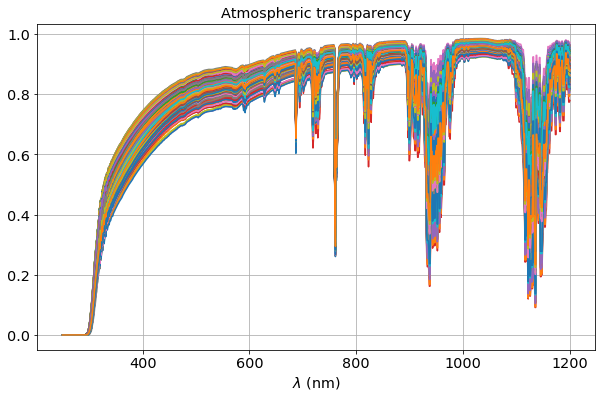

In [151]:
for idx in np.arange(1,NbAtmSimul+1):
    plt.plot(data_atm[0],data_atm[idx])
plt.grid(True)
plt.xlabel("$\lambda$ (nm)")
plt.title("Atmospheric transparency")

# output file

In [125]:
NBROW=NbAtmSimul+1
NBCOL=idx_out_res+nbcols

In [126]:
data_out=np.zeros((NBROW,NBCOL))

In [131]:
data_out[0,idx_out_res:]=data_atm[0]
for idx in np.arange(1,NBROW):
    data_out[idx,idx_out_num]=idx-1
    data_out[idx,idx_out_night]=df['nights'].iloc[idx-1]
    data_out[idx,idx_out_expdate]=df['expdate'].iloc[idx-1]
    data_out[idx,idx_out_expmjd]=df['expmjd'].iloc[idx-1]
    data_out[idx,idx_out_am]=df['airmass'].iloc[idx-1]
    filtnum=photo.band_to_number_2[df['filter'].iloc[idx-1]] # convert filter into number
    data_out[idx,idx_out_filt]=filtnum
    data_out[idx,idx_out_vaod]=df['vaod'].iloc[idx-1]
    data_out[idx,idx_out_pwv]=df['pwv'].iloc[idx-1]
    data_out[idx,idx_out_o3]=df['o3'].iloc[idx-1]
    data_out[idx,idx_out_res:]=data_atm[idx]


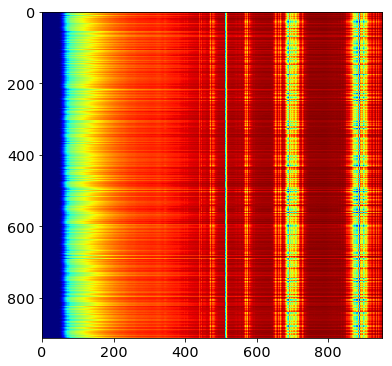

In [133]:
plt.imshow(data_out[1:,idx_out_res:],cmap='jet')

In [134]:
hdr = fits.Header()
hdr['NBATMSIM']=NbAtmSimul
hdr['ID_NUM']=idx_out_num
hdr['ID_NIGHT']=idx_out_night
hdr['ID_DATE']=idx_out_expdate
hdr['ID_EXMJD']=idx_out_expmjd
hdr['ID_AM']=idx_out_am
hdr['ID_FILT']=idx_out_filt
hdr['ID_VAOD']=idx_out_vaod
hdr['ID_PWV']=idx_out_pwv
hdr['ID_O3']=idx_out_o3
hdr['ID_RES']=idx_out_res

hdu = fits.PrimaryHDU(data_out,header=hdr)
hdu.writeto(output_file,overwrite=True)

In [135]:
data_out.shape

(913, 960)

Text(0.5,0,'$\\lambda$ (nm)')

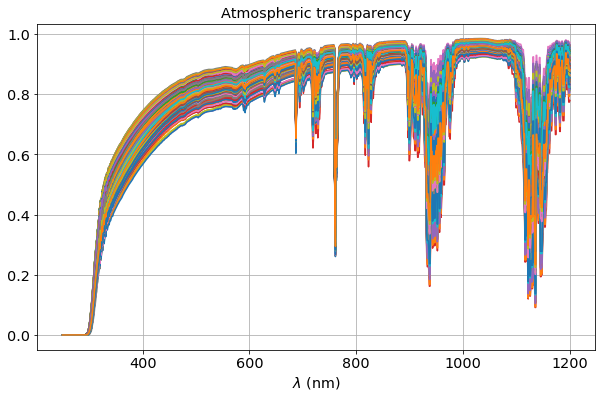

In [154]:
for idx in np.arange(1,NbAtmSimul+1):
    plt.plot(data_out[0,idx_out_res:],data_out[idx,idx_out_res:])
#   plt.plot(data_out[0,idx_out_res:],data_out[912,idx_out_res:])
plt.grid(True)
plt.title("Atmospheric transparency")
plt.xlabel("$\lambda$ (nm)")

Text(0.5,0,'airmass')

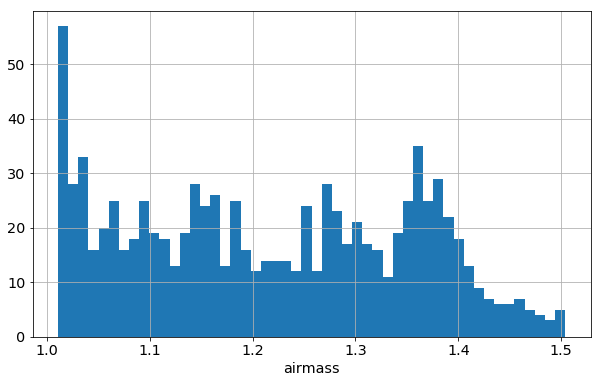

In [153]:
plt.hist(data_out[1:,idx_out_am],bins=50);
plt.grid(True)
plt.xlabel("airmass")